In [2]:
# Verify kernel is using the correct environment
import sys
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print(f"Using UV environment: {'/root/.venv' in sys.executable}")

Python executable: /root/.venv/bin/python
Python version: 3.11.14 (main, Oct 14 2025, 21:26:53) [Clang 20.1.4 ]
Using UV environment: True


# THRML TV Station Channel Assignment - Potts Model Sampling

This notebook runs a THRML Potts sampler on an FCC TVGraph to find valid channel assignments.

**Setup Instructions:**
1. In VS Code, click "Select Kernel" in the top-right
2. Choose "Select Another Kernel..." → "Python Environments..."
3. Select the interpreter at: `/root/.venv/bin/python3`

If it doesn't appear, restart VS Code or manually enter the path when prompted.

In [3]:
# Import required libraries
from __future__ import annotations

import os
from collections import Counter
from pathlib import Path
import sys

# Force CPU to avoid GPU memory issues with large graphs
os.environ.setdefault('JAX_PLATFORMS', 'cpu')

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Add tools directory to path
sys.path.insert(0, str(Path.cwd() / 'tools'))

from tv_graph import TVGraph
from thrml import Block, BlockGibbsSpec, FactorSamplingProgram, SamplingSchedule, sample_states
from thrml.block_management import block_state_to_global
from thrml.block_sampling import sample_blocks
from thrml.models import CategoricalEBMFactor, CategoricalGibbsConditional
from thrml.models.ebm import DEFAULT_NODE_SHAPE_DTYPES
from thrml.pgm import CategoricalNode

## Configuration

In [14]:
# Configuration parameters
INPUT_FOLDER = Path("input/fcc-post-auction-2047st-34ch")  # Change to "input/fcc" for full dataset
LAMBDA_CONFLICT = 8.0  # Energy penalty for triggering a constraint
LAMBDA_DOMAIN = 100.0  # Penalty for leaving a station domain
WARMUP_STEPS = 200
NUM_SAMPLES = 200
STEPS_PER_SAMPLE = 1
SEED = 0

# Visualization settings
VIZ_EVERY = 10  # Update visualization every N steps
SHOW_EDGES = True
MARKER_SIZE = 36.0

## Load Graph Data

In [15]:
# Load the TV graph
graph = TVGraph(INPUT_FOLDER)
print(f"Loaded graph with {graph.station_count:,} stations and {graph.channel_count:,} channels.")

Loaded graph with 2,047 stations and 34 channels.


## Helper Functions

In [16]:
def make_domain_factor(graph: TVGraph, nodes: list[CategoricalNode], penalty: float) -> CategoricalEBMFactor:
    """
    Encode station-specific channel domains via a unary CategoricalEBMFactor.
    """
    station_count = len(nodes)
    channel_count = graph.channel_count
    weights = np.full((station_count, channel_count), -float(penalty), dtype=np.float32)
    for station in graph.stations_by_id.values():
        if station.station_index is None:
            raise ValueError(f"Station {station.station_id} is missing a contiguous index.")
        weights[station.station_index, station.domain_indices] = 0.0
    return CategoricalEBMFactor([Block(nodes)], jnp.asarray(weights))


def make_interference_factor(
    graph: TVGraph,
    nodes: list[CategoricalNode],
    penalty: float,
) -> CategoricalEBMFactor | None:
    """
    Create a pairwise Potts factor that penalises channel combinations forbidden by FCC constraints.
    """
    seen: set[tuple[int, int, int, int]] = set()
    constraint_rows: list[tuple[int, int, int, int]] = []
    for station in graph.stations_by_id.values():
        if station.station_index is None:
            continue
        a_idx = station.station_index
        for interference, partner_idx in station.interferences_deduped():
            a_chan_idx = interference.subject_channel_index
            b_chan_idx = interference.other_channel_index
            key = (a_idx, partner_idx, a_chan_idx, b_chan_idx)
            if key in seen:
                raise ValueError(f"Duplicate constraint: {key}")
            seen.add(key)
            constraint_rows.append(key)

    if not constraint_rows:
        return None

    channel_count = graph.channel_count
    edge_count = len(constraint_rows)
    weights = np.zeros((edge_count, channel_count, channel_count), dtype=np.float32)
    head_nodes: list[CategoricalNode] = []
    tail_nodes: list[CategoricalNode] = []

    for idx, (a_idx, b_idx, a_chan_idx, b_chan_idx) in enumerate(constraint_rows):
        head_nodes.append(nodes[a_idx])
        tail_nodes.append(nodes[b_idx])
        weights[idx, a_chan_idx, b_chan_idx] = -float(penalty)

    return CategoricalEBMFactor([Block(head_nodes), Block(tail_nodes)], jnp.asarray(weights))


def prepare_initial_state(
    graph: TVGraph, free_blocks: list[Block], seed: int
) -> tuple[list[jnp.ndarray], int, int]:
    """
    Build the sampler's initial block state, preferring post-auction channel assignments.
    """
    key = jax.random.PRNGKey(seed)
    init_state: list[jnp.ndarray] = []
    post_count = 0
    random_count = 0
    for station_index, block in enumerate(free_blocks):
        station_id = graph.station_id_for_index(station_index)
        station = graph.station(station_id)
        new_channel = station.new_channel
        if new_channel is not None:
            if new_channel not in graph.channel_values:
                channel_idx = graph.channel_count - 1
            else:
                channel_idx = graph.channel_index_for_channel(new_channel)
            post_count += 1
        else:
            domain = np.asarray(station.domain_indices, dtype=np.int32)
            if domain.size == 0:
                raise ValueError(f"Station {station.station_id} has an empty domain.")
            key, subkey = jax.random.split(key)
            channel_idx = int(jax.random.choice(subkey, domain))
            random_count += 1
        init_state.append(jnp.asarray([channel_idx], dtype=jnp.uint8))
    return init_state, post_count, random_count


def block_assignment_to_array(block_state: list[jnp.ndarray]) -> np.ndarray:
    """
    Flatten a block-aligned state into a 1-D NumPy vector of channel indices.
    """
    return np.asarray([int(np.asarray(block).item()) for block in block_state], dtype=np.int32)


def evaluate_energy(program: FactorSamplingProgram, factors: list[CategoricalEBMFactor], block_state: list[jnp.ndarray]) -> float:
    """
    Sum factor energies for a block state.
    """
    global_state = block_state_to_global(list(block_state), program.gibbs_spec)
    total = 0.0
    for factor in factors:
        total += float(factor.energy(global_state, program.gibbs_spec))
    return total


def score_assignment(graph: TVGraph, assignment: np.ndarray) -> dict[str, object]:
    """
    Measure constraint violations for a channel assignment vector.
    """
    channel_values = graph.channel_for_channel_id
    domain_mask = graph.domain_mask
    domain_violations = 0
    for station_index, channel_index in enumerate(assignment):
        if not domain_mask[station_index, channel_index]:
            domain_violations += 1

    violations = 0
    violations_by_type: Counter[str] = Counter()
    seen_pairs: set[tuple[int, int, int, int]] = set()

    for station in graph.stations_by_id.values():
        if station.station_index is None:
            continue
        a_idx = station.station_index
        assigned_a_idx = int(assignment[a_idx])
        assigned_a_val = channel_values[assigned_a_idx]

        for interference in station.interferences:
            if assigned_a_val != interference.subject_channel:
                continue
            for partner_idx in interference.station_indices:
                assigned_b_idx = int(assignment[partner_idx])
                assigned_b_val = channel_values[assigned_b_idx]
                if assigned_b_val != interference.other_channel:
                    continue

                if a_idx <= partner_idx:
                    key = (a_idx, partner_idx, assigned_a_idx, assigned_b_idx)
                    constraint_type = interference.constraint_type
                else:
                    key = (partner_idx, a_idx, assigned_b_idx, assigned_a_idx)
                    constraint_type = interference.constraint_type

                if key in seen_pairs:
                    continue
                seen_pairs.add(key)
                violations += 1
                violations_by_type[constraint_type] += 1

    return {
        "domain_violations": domain_violations,
        "violations": violations,
        "violations_by_type": violations_by_type,
    }

## Build THRML Components

In [ ]:
print("→ Creating THRML categorical nodes (one per station) and single-node Gibbs blocks.")
nodes = [CategoricalNode() for _ in graph.station_ids_by_index]
free_blocks = [Block([node]) for node in nodes]

print("→ Wiring domain factor: disallowed channels receive λ_domain energy penalty.")
domain_factor = make_domain_factor(graph, nodes, penalty=LAMBDA_DOMAIN)

print("→ Wiring pairwise Potts factor: λ_conflict penalises forbidden channel pairings.")
conflict_factor = make_interference_factor(graph, nodes, penalty=LAMBDA_CONFLICT)

if conflict_factor is None:
    print("→ No interference pairs detected; only unary factors are active.")
    factors = [domain_factor]
else:
    factors = [domain_factor, conflict_factor]

gibbs_spec = BlockGibbsSpec(
    free_super_blocks=free_blocks,
    clamped_blocks=[],
    node_shape_dtypes=DEFAULT_NODE_SHAPE_DTYPES,
)
samplers = [CategoricalGibbsConditional(graph.channel_count) for _ in free_blocks]
program = FactorSamplingProgram(gibbs_spec, samplers, factors, other_interaction_groups=[])
print("→ Compiled FactorSamplingProgram with categorical Gibbs conditionals.")

init_state, init_post_count, init_random_count = prepare_initial_state(graph, free_blocks, SEED)
print(f"→ Initial state: {init_post_count} post-auction, {init_random_count} random draws.")

→ Creating THRML categorical nodes (one per station) and single-node Gibbs blocks.
→ Wiring domain factor: disallowed channels receive λ_domain energy penalty.
→ Wiring pairwise Potts factor: λ_conflict penalises forbidden channel pairings.


## Check Initial State

In [ ]:
initial_assignment = block_assignment_to_array(init_state)
init_energy = evaluate_energy(program, factors, init_state)
init_stats = score_assignment(graph, initial_assignment)

print(f"Initial state: energy={init_energy:.2f}, "
      f"violations={init_stats['violations']}, "
      f"domain breaches={init_stats['domain_violations']}")

Initial state: energy=1296.00, violations=162, domain breaches=0


## Run Gibbs Sampling with Visualization

In [ ]:
# Set up inline plotting
%matplotlib inline

from tv_live_viz import MatplotlibSamplerViz

# Create visualizer
viz = MatplotlibSamplerViz(
    graph,
    marker_size=MARKER_SIZE,
    show_edges=SHOW_EDGES,
)

# Sampling loop with visualization
key = jax.random.PRNGKey(SEED ^ 0xFEED5EED)
state_free = [jnp.asarray(block) for block in init_state]
clamp_state = []
sampler_states = [sampler.init() for sampler in program.samplers]

samples = []
step = 0

# Initial update
assignment = block_assignment_to_array(state_free)
domain_mask, edge_mask = viz.compute_violation_masks(assignment)
energy = evaluate_energy(program, factors, state_free)
viz.update(step, assignment, domain_mask, edge_mask, energy)

print(f"Running warmup: {WARMUP_STEPS} steps")
# Warmup
for i in range(WARMUP_STEPS):
    step += 1
    key, subkey = jax.random.split(key)
    state_free, sampler_states = sample_blocks(
        subkey,
        state_free,
        clamp_state,
        program,
        sampler_states,
    )
    
    if step % VIZ_EVERY == 0:
        assignment = block_assignment_to_array(state_free)
        domain_mask, edge_mask = viz.compute_violation_masks(assignment)
        energy = evaluate_energy(program, factors, state_free)
        viz.update(step, assignment, domain_mask, edge_mask, energy)
        if (i + 1) % 50 == 0:
            print(f"  Warmup step {i + 1}/{WARMUP_STEPS}")

# Final warmup update
assignment = block_assignment_to_array(state_free)
domain_mask, edge_mask = viz.compute_violation_masks(assignment)
energy = evaluate_energy(program, factors, state_free)
viz.update(step, assignment, domain_mask, edge_mask, energy)
samples.append(assignment.copy())

print(f"Collecting samples: {NUM_SAMPLES} samples")
# Sampling
for i in range(1, NUM_SAMPLES):
    for _ in range(STEPS_PER_SAMPLE):
        step += 1
        key, subkey = jax.random.split(key)
        state_free, sampler_states = sample_blocks(
            subkey,
            state_free,
            clamp_state,
            program,
            sampler_states,
        )
        
        if step % VIZ_EVERY == 0:
            assignment = block_assignment_to_array(state_free)
            domain_mask, edge_mask = viz.compute_violation_masks(assignment)
            energy = evaluate_energy(program, factors, state_free)
            viz.update(step, assignment, domain_mask, edge_mask, energy)
    
    assignment = block_assignment_to_array(state_free)
    domain_mask, edge_mask = viz.compute_violation_masks(assignment)
    energy = evaluate_energy(program, factors, state_free)
    viz.update(step, assignment, domain_mask, edge_mask, energy)
    samples.append(assignment.copy())
    
    if (i + 1) % 50 == 0:
        print(f"  Sample {i + 1}/{NUM_SAMPLES}")

samples = np.stack(samples, axis=0)
print(f"Sampling complete. Collected {len(samples)} samples.")

Running warmup: 200 steps
  Warmup step 50/200
  Warmup step 50/200
  Warmup step 100/200
  Warmup step 100/200
  Warmup step 150/200
  Warmup step 150/200
  Warmup step 200/200
  Warmup step 200/200
  Sample 50/200
  Sample 50/200
  Sample 100/200
  Sample 100/200
  Sample 150/200
  Sample 150/200
  Sample 200/200
Sampling complete. Collected 200 samples.
  Sample 200/200
Sampling complete. Collected 200 samples.


## Find Best Sample

In [ ]:
best_index = 0
best_assignment = samples[0]
best_stats = score_assignment(graph, best_assignment)
best_energy = evaluate_energy(
    program, factors, [jnp.asarray([value], dtype=jnp.uint8) for value in best_assignment]
)

for idx in range(1, samples.shape[0]):
    assignment = samples[idx]
    stats = score_assignment(graph, assignment)
    energy = evaluate_energy(program, factors, [jnp.asarray([value], dtype=jnp.uint8) for value in assignment])
    if stats["violations"] < best_stats["violations"] or (
        stats["violations"] == best_stats["violations"] and energy < best_energy
    ):
        best_index = idx
        best_stats = stats
        best_energy = energy

print(f"Best sample #{best_index}: energy={best_energy:.2f}, "
      f"violations={best_stats['violations']}, "
      f"domain breaches={best_stats['domain_violations']}")

violations_by_type = best_stats["violations_by_type"]
if isinstance(violations_by_type, Counter) and violations_by_type:
    print("\nConstraint hits by type:")
    for constraint_type, count in violations_by_type.most_common():
        print(f"  {constraint_type:<8} {count}")

Best sample #9: energy=48.00, violations=6, domain breaches=0

Constraint hits by type:
  CO       6


## Display Best Assignment Preview

In [ ]:
post_channels = graph.channel_values[best_assignment]
print("Sample assignment preview (station_id → channel):")
preview = min(20, graph.station_count)
for station_id, channel in zip(graph.station_ids_by_index[:preview], post_channels[:preview]):
    print(f"  {station_id:<8} → {channel}")
if graph.station_count > preview:
    print(f"  ... ({graph.station_count - preview} more stations)")

Sample assignment preview (station_id → channel):
  87       → 13
  1005     → 6
  2566     → 7
  2767     → 7
  6864     → 14
  7078     → 19
  7675     → 10
  8986     → 7
  10265    → 14
  11034    → 7
  11910    → 9
  12508    → 8
  14885    → 6
  17433    → 18
  18283    → 16
  23422    → 20
  24485    → 6
  25382    → 19
  29557    → 20
  29560    → 12
  ... (30 more stations)


## Display Final Visualization State

The visualization shows:
- **Node colors**: Channel assignments (using tab20 color palette)
- **Red node borders**: Domain violations
- **Red edges**: Interference constraint violations
- **Bottom plot**: Energy trajectory over sampling steps

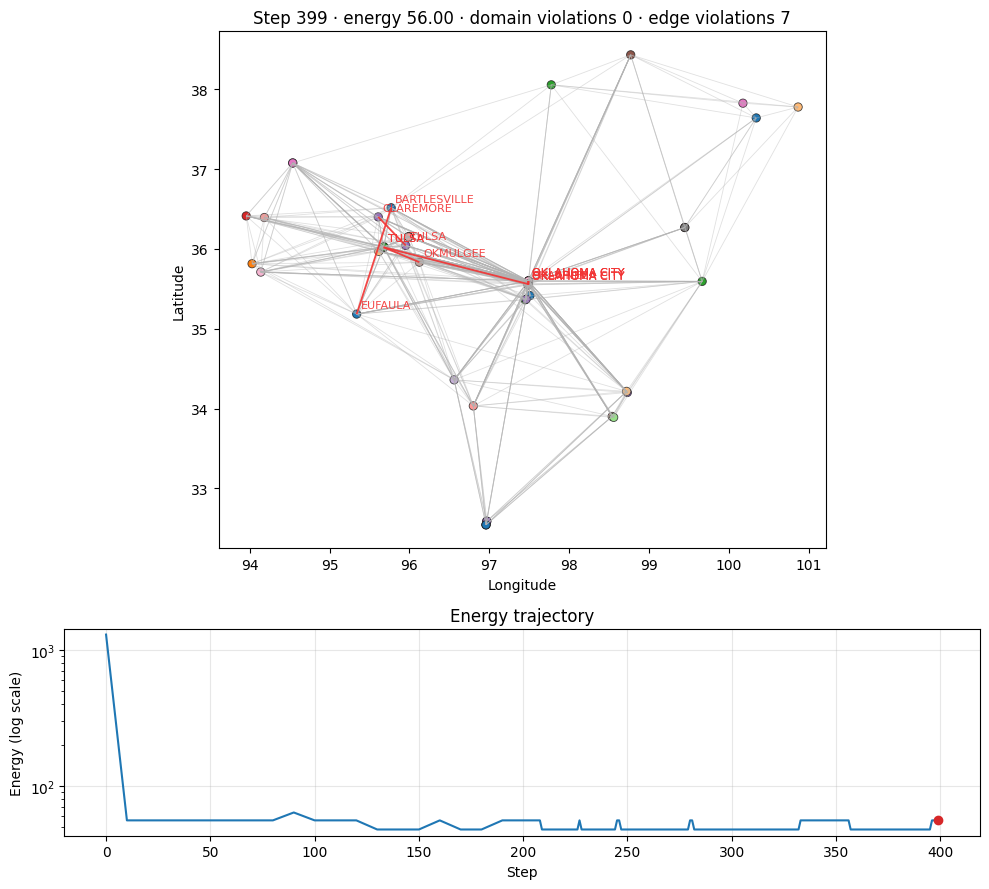

In [ ]:
# Display the final visualization
from IPython.display import display
display(viz.figure)